
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/092_Counterfactual_Explanations.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/92_Counterfactual_Explanations.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🔄 Counterfactual Explanations: "Co by było, gdyby?"

LIME i SHAP odpowiadają na pytanie: *"Dlaczego tak?"*.
Counterfactuals odpowiadają na pytanie: *"Co zrobić, żeby było inaczej?"*.

To kluczowe w prawie (GDPR/RODO) i biznesie.
Przykład:
*   **Stan obecny:** Klient X, Zarobki 3000, Wiek 20 -> Kredyt: ODMOWA.
*   **Counterfactual:** Klient X, Zarobki **3500**, Wiek 20 -> Kredyt: ZGODA.

Szukamy nowego punktu $x'$, który:
1.  Daje inny wynik niż $x$ (Przekracza próg decyzyjny).
2.  Jest jak najbliżej oryginału $x$ (Minimalna zmiana - ang. *Sparsity*).

Zastosujemy to do diagnozy medycznej (zbiór Breast Cancer). Znajdziemy najmniejszą zmianę w wynikach badań, która zmieni diagnozę z "Złośliwy" na "Łagodny".

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 1. DANE I MODEL
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target
target_names = data.target_names # ['malignant' (0), 'benign' (1)]

# Trenujemy model
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X, y)

print("Model gotowy.")
print(f"Klasy: 0={target_names[0]}, 1={target_names[1]}")

Model gotowy.
Klasy: 0=malignant, 1=benign


## Wybór Pacjenta

Wybierzmy pacjenta, który ma diagnozę **Malignant (0 - Złośliwy)**.
Chcemy znaleźć, co musiałoby się zmienić w jego wynikach, żeby model uznał go za **Benign (1 - Łagodny)**.

In [5]:
# Szukamy pacjenta z klasy 0 (Malignant)
malignant_indices = np.where(y == 0)[0]
patient_idx = malignant_indices[0] # Bierzemy pierwszego z brzegu

# Wyciągamy dane jako Serię pandas
patient_data = X.iloc[patient_idx]

# --- POPRAWKA (Fix Warning) ---
# Zamieniamy pojedynczą serię na DataFrame (1 wiersz), żeby zachować nazwy kolumn.
# Scikit-learn przestanie krzyczeć.
patient_df_row = patient_data.to_frame().T

original_pred = model.predict(patient_df_row)[0]
original_prob = model.predict_proba(patient_df_row)[0]

print(f"Pacjent ID: {patient_idx}")
print(f"Diagnoza: {target_names[original_pred]} (Pewność: {original_prob[original_pred]:.2f})")
print("Cel: Zmienić diagnozę na 'benign' (1).")

Pacjent ID: 0
Diagnoza: malignant (Pewność: 0.98)
Cel: Zmienić diagnozę na 'benign' (1).


## Algorytm: Greedy Counterfactual Search

Ponieważ Random Forest nie jest różniczkowalny (nie ma gradientu), użyjemy metody **zachłannej (Greedy)**.

1.  Sprawdź ważność cech (Feature Importance) - wiemy, które cechy model lubi najbardziej.
2.  Iteruj po najważniejszych cechach.
3.  Zmieniaj ich wartość (np. zmniejszaj/zwiększaj o odchylenie standardowe).
4.  Sprawdzaj, czy decyzja modelu się zmieniła.
5.  Jeśli tak -> STOP. Mamy to.

In [9]:
def generate_counterfactual(model, instance, dataset_std, step_size=0.5, max_steps=50):
    """
    Ulepszony generator: Zmienia cechy KUMULATYWNIE.
    Jeśli zmiana jednej cechy nie wystarcza, zostawia ją zmienioną i bierze się za kolejną.
    """
    # Kopiujemy instancję na start
    best_cf = instance.copy()
    
    # Pobieramy ważność cech
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1] # Od najważniejszych
    feature_names = instance.index
    
    # Sprawdzamy klasę oryginału
    instance_df = instance.to_frame().T
    original_class = model.predict(instance_df)[0]
    
    print(f"Szukanie kontrfaktu (Strategia Kumulacyjna)... Klasa startowa: {original_class}")
    
    # Pętla po najważniejszych cechach
    for feature_idx in sorted_indices:
        feature_name = feature_names[feature_idx]
        std = dataset_std[feature_name]
        
        # Próbujemy ruszyć tę cechę w obu kierunkach
        for direction in [-1, 1]:
            # Pracujemy na KOPII aktualnie najlepszego rozwiązania (nie resetujemy do zera!)
            current_cf = best_cf.copy()
            
            for step in range(max_steps):
                # Zmiana wartości
                change = direction * step_size * std
                current_cf[feature_name] += change
                
                # Sprawdzenie
                current_cf_df = current_cf.to_frame().T
                new_pred = model.predict(current_cf_df)[0]
                
                if new_pred != original_class:
                    print(f"✅ SUKCES! Przełamano decyzję.")
                    print(f"   Ostatnia zmiana: {feature_name} (Krok {step+1})")
                    return current_cf
            
            # Jeśli ta cecha w tym kierunku ZMNIEJSZYŁA pewność modelu (nawet jeśli nie przełączyła klasy),
            # to ją zachowujemy! (Heurystyka)
            # Sprawdźmy prawdopodobieństwo starej klasy
            old_prob = model.predict_proba(best_cf.to_frame().T)[0][original_class]
            new_prob = model.predict_proba(current_cf.to_frame().T)[0][original_class]
            
            if new_prob < old_prob:
                print(f"   -> Zatrzymujemy zmianę w '{feature_name}' (Pewność spadła do {new_prob:.2f})")
                best_cf = current_cf # Nadpisujemy bazę!
                break # Idziemy do następnej cechy
                
    print("❌ Nie udało się mimo prób.")
    return None

# Potrzebujemy odchyleń standardowych
std_devs = X.std()

# Uruchamiamy (z większym krokiem dla pewności)
counterfactual = generate_counterfactual(model, patient_data, std_devs, step_size=1.0)

Szukanie kontrfaktu (Strategia Kumulacyjna)... Klasa startowa: 0
   -> Zatrzymujemy zmianę w 'worst concave points' (Pewność spadła do 0.84)
   -> Zatrzymujemy zmianę w 'mean concave points' (Pewność spadła do 0.68)
   -> Zatrzymujemy zmianę w 'worst radius' (Pewność spadła do 0.54)
   -> Zatrzymujemy zmianę w 'mean perimeter' (Pewność spadła do 0.52)
✅ SUKCES! Przełamano decyzję.
   Ostatnia zmiana: worst area (Krok 2)



Nowa Diagnoza: benign
Pewność 'benign' (1): 0.58

--- RECEPTA (Co zmienić?) ---


,Oryginał,Zalecane,Zmiana
mean perimeter,122.8000,-1092.149052,-1214.949052
mean concave points,0.1471,-1.793042,-1.940142
worst radius,25.3800,-216.282079,-241.662079
worst area,2019.0000,880.286015,-1138.713985
worst concave points,0.2654,-3.021217,-3.286617


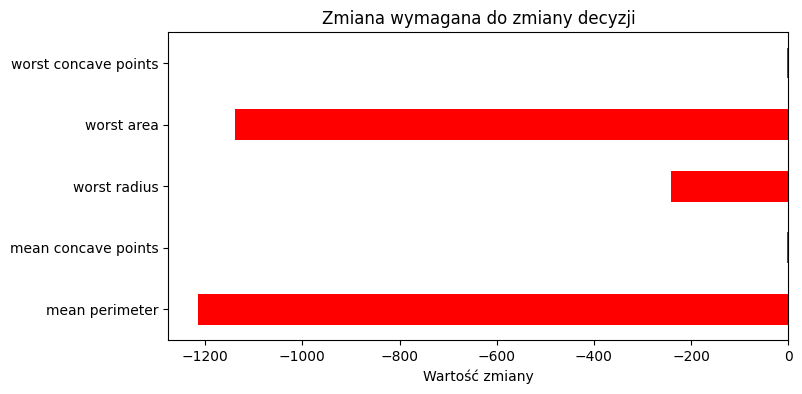

In [11]:
# WIZUALIZACJA ZMIAN

if counterfactual is not None:
    # --- POPRAWKA: Konwersja na DataFrame ---
    # To jest ten moment, który generował ostrzeżenia.
    # Zamieniamy wynik na DataFrame, żeby model widział nazwy kolumn.
    cf_df = counterfactual.to_frame().T
    
    # Nowa predykcja (już na DataFrame)
    new_prob = model.predict_proba(cf_df)[0]
    new_class = model.predict(cf_df)[0]
    
    print(f"\nNowa Diagnoza: {target_names[new_class]}")
    print(f"Pewność 'benign' (1): {new_prob[1]:.2f}")
    
    # Rysujemy różnice
    diff = counterfactual - patient_data
    # Filtrujemy tylko te cechy, które się zmieniły
    changed_features = diff[diff != 0]
    
    print("\n--- RECEPTA (Co zmienić?) ---")
    results_df = pd.DataFrame({
        'Oryginał': patient_data[changed_features.index],
        'Zalecane': counterfactual[changed_features.index],
        'Zmiana': changed_features
    })
    display(results_df)
    
    # Wykres
    plt.figure(figsize=(8, 4))
    colors = ['green' if x > 0 else 'red' for x in changed_features]
    changed_features.plot(kind='barh', color=colors)
    plt.title("Zmiana wymagana do zmiany decyzji")
    plt.xlabel("Wartość zmiany")
    plt.show()
else:
    print("Brak rozwiązania do wizualizacji.")

## 🧠 Podsumowanie: Actionable Insights

Czym to się różni od Feature Importance?
*   **Feature Importance:** "Dla modelu ważny jest `worst perimeter`". (Informacja teoretyczna).
*   **Counterfactual:** "Jeśli Twój `worst perimeter` spadnie o 15.3, model zmieni zdanie". (Informacja operacyjna).

**Wnioski dla biznesu:**
To narzędzie daje klientowi **plan działania**.
Zamiast mówić: "Masz zły profil", mówisz: "Zwiększ obroty o 10% LUB wydłuż historię kredytową o rok, a dostaniesz pożyczkę".